# Figure: Colocalization Analysis
## CENP-C and DNA-FISH Colocalization Ratio Bar Chart

This notebook generates the bar chart showing colocalization ratios across different experimental groups and timepoints.

In [ ]:
# =============================================================================
# Figure : Colocalization Analysis Setup and Imports
# =============================================================================

import os
import numpy as n
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, ConnectionPatch
from skimage.draw import disk
from skimage import io
from scipy.spatial.distance import cdist

# Configure matplotlib for publication-quality plots
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']

print("Figure 2 Colocalization Analysis - Libraries imported successfully")

Figure 2 Colocalization Analysis - Libraries imported successfully


In [25]:
import os
import numpy as np
import pandas as pd
from skimage.draw import disk
from skimage import io
from scipy.spatial.distance import cdist

def get_colocalization_intensity(root_dir: str, threshold: float = 2, distance_threshold: float = 5) -> pd.DataFrame:
    """
    For each subfolder in `root_dir`:
      - Loads 'dna_fish_centroids.npy' and 'cenpc_centroids.npy'
      - Loads segmentation from 'common_nuclei.npy'
      - Loads the CENPC image ending with '679.tif'
      - For each nucleus, counts DNA-FISH and CENPC centroids within valid chromosomes,
        checks if any DNA-FISH centroid overlaps with CENPC centroid within the same nucleus,
        and skips if the CENPC centroid is too close to the DNA-FISH centroid.
    Returns:
        pandas.DataFrame with columns ['folder', 'total_dna_fish_spots', 'total_cenpc_centroids', 'colocalized_nuclei']
    """
    records = []
    
    for sub in sorted(os.listdir(root_dir)):
        folder = os.path.join(root_dir, sub)
        if not os.path.isdir(folder):
            continue
        
        inter = os.path.join(folder, 'intermediate_results')
        
        # Paths to files
        dna_path  = os.path.join(inter, 'dna_fish_centroids.npy')
        common_nuc_path  = os.path.join(inter, 'common_nuclei.npy')
        cenpc_centroid_path = os.path.join(inter, 'cenpc_centroids.npy')
        
        # Search for CENPC image file ending with '679.tif'
        tif_name = next((f for f in os.listdir(folder) if f.endswith('679.tif')), None)
        if tif_name is None:
            print(f" → No 679.tif found in {folder}, skipping.")
            continue
        tif_path = os.path.join(folder, tif_name)
        
        # Skip if any file is missing
        if not (os.path.exists(dna_path) and os.path.exists(common_nuc_path) and os.path.exists(tif_path)):
            continue
        
        # Load data
        dna_centroids  = np.load(dna_path).astype(int)
        common_mask    = np.load(common_nuc_path).astype(int)
        
        # Load the CENPC image (TIFF file)
        cenpc_image = io.imread(tif_path)
        
        # Image dimensions
        H, W = cenpc_image.shape
        
        # Find all nucleus labels (valid chromosomes) from common mask
        labels_common = np.unique(common_mask)
        labels_common = labels_common[labels_common != 0]  # Skip background
        
        total_dna_fish_spots = 0
        total_cenpc_centroids = 0
        coloc_count = 0

                        # Calculate the distance from the DNA-FISH centroid to each CENPC centroid
        cenpc_centroids = np.load(cenpc_centroid_path).astype(int)
        # Calculate the background mean intensity
        background_mean = np.mean(cenpc_image[common_mask==0])


        for lbl in labels_common:
            # Find DNA-FISH centroids that fall within the current chromosome (nucleus)
            dna_in_nuc = [tuple(c) for c in dna_centroids if common_mask[tuple(c)] == lbl]
            
            # Find CENPC centroids within the same chromosome (nucleus)
            cenpc_in_nuc = [tuple(c) for c in cenpc_centroids if common_mask[tuple(c)] == lbl]
            
            # For each DNA-FISH spot, check the intensity in the CENPC channel
            for (r, c) in dna_in_nuc:
                # Create a disk (circle) around the DNA-FISH centroid
                rr, cc = disk((r, c), radius=4, shape=cenpc_image.shape)
                
                # Clip rr, cc to ensure they are within image boundaries
                rr = np.clip(rr, 0, H - 1)  # Clip to image height
                cc = np.clip(cc, 0, W - 1)  # Clip to image width
                
                # Calculate the intensity in the CENPC channel (cenpc_image)
                cenpc_intensity = cenpc_image[rr, cc].mean()  # Mean intensity within the disk
        
                # Compute the distance between the DNA-FISH centroid and all CENPC centroids in the same nucleus
                distances = cdist([(r, c)], cenpc_in_nuc)  # Compute Euclidean distance
                
                # Check if any CENPC centroid is within the distance threshold
                if np.any(distances < distance_threshold):
                    # Skip this DNA-FISH centroid if there's a nearby CENPC centroid
                    continue
                
                # If the intensity is above the threshold, count as colocalized
                if cenpc_intensity >= (background_mean * threshold):
                    coloc_count += 1
            
            # Count the total number of DNA-FISH spots in the nucleus
            total_dna_fish_spots += len(dna_in_nuc)

        
        # Record the results for this folder
        records.append({
            'folder': sub,
            'total_dna_fish_spots': total_dna_fish_spots,
            'colocalized_nuclei': coloc_count
        })
    
    # Return as a DataFrame
    return pd.DataFrame.from_records(records)


In [ ]:
# colocalization
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Directories for the three timepoints and scrambled data
scrambled_data = '/vf/users/sagarm2/cellpose_chr/PaperData/Worked/Worked/72h_KD_CpC_8q/Scram_72h_CpC/'
directory_72h = '/vf/users/sagarm2/cellpose_chr/PaperData/Worked/Worked/72h_KD_CpC_8q/PCAT2_72h_CpC/'
directory_96h = '/vf/users/sagarm2/cellpose_chr/PaperData/Worked/Worked/D3_KD_CpC_8q_10p(96h)/PCAT2/'
directory_120h = '/vf/users/sagarm2/cellpose_chr/PaperData/Worked/Worked/D5_KD_CpC_8q_10p(120h)/PCAT2_rep_8q_10p_Cpc/'


threshold = 1.2
distance_threshold = 10



# Assuming get_colocalization_counts_same_chromosome function is defined
df_scramble  = get_colocalization_intensity(scrambled_data, threshold, distance_threshold)
df_scramble['timepoint'] = 'scrambled'
df_72h  = get_colocalization_intensity(directory_72h, threshold*1.2, distance_threshold)
df_72h['timepoint'] = '72h'
df_96h  = get_colocalization_intensity(directory_96h, threshold*1.2, distance_threshold)
df_96h['timepoint'] = '96h'
df_120h = get_colocalization_intensity(directory_120h, threshold*1.2, distance_threshold)
df_120h['timepoint'] = '120h'

# Combine all data into one DataFrame
df_all = pd.concat([df_scramble, df_72h, df_96h, df_120h], ignore_index=True)

# Calculate the ratio for each timepoint and scrambled data
ratios = {
    'scrambled': np.sum(df_scramble['colocalized_nuclei']) / np.sum(df_scramble['total_dna_fish_spots']),
    '72h': np.sum(df_72h['colocalized_nuclei']) / np.sum(df_72h['total_dna_fish_spots']),
    '96h': np.sum(df_96h['colocalized_nuclei']) / np.sum(df_96h['total_dna_fish_spots']),
    '120h': np.sum(df_120h['colocalized_nuclei']) / np.sum(df_120h['total_dna_fish_spots'])
}

# Plot the ratios
timepoints = list(ratios.keys())

values = list(ratios.values())

# Create bar plot with customized styling




In [30]:
# =============================================================================
# Colocalization Ratio Analysis with Group Splitting for Statistical Analysis
# =============================================================================

import numpy as np
import pandas as pd

def group_ratios(df):
    """
    Split dataset in half and calculate colocalization ratios for each half.
    
    This function implements a data splitting approach for statistical analysis by:
    1. Dividing the dataset into two equal halves (first half vs second half)
    2. Calculating colocalization ratios for each half separately
    3. Providing two independent measurements for error estimation
    
    This approach is useful for:
    - Estimating variability within experimental conditions
    - Generating error bars for plotting
    - Assessing reproducibility across different data subsets
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing colocalization results with columns:
        - 'colocalized_nuclei': Number of colocalized spots
        - 'total_dna_fish_spots': Total number of DNA-FISH spots analyzed
        
    Returns:
    --------
    list
        Two colocalization ratios: [ratio_first_half, ratio_second_half]
        Each ratio = colocalized_nuclei / total_dna_fish_spots for that half
    """
    # Get total number of samples (images/folders) in the dataset
    n = len(df)
    
    # Calculate midpoint to split dataset in half
    half = n // 2  # Integer division ensures clean split
    
    # Split dataset into two groups
    # First half: samples 0 to (half-1)
    group1 = df.iloc[:half]
    
    # Second half: samples (half) to end
    group2 = df.iloc[half:]
    
    # Calculate colocalization ratio for first half
    # Ratio = total colocalized spots / total DNA-FISH spots in first half
    total_coloc_g1 = np.sum(group1['colocalized_nuclei'])
    total_spots_g1 = np.sum(group1['total_dna_fish_spots'])
    ratio1 = total_coloc_g1 / total_spots_g1 if total_spots_g1 > 0 else np.nan
    
    # Calculate colocalization ratio for second half
    # Ratio = total colocalized spots / total DNA-FISH spots in second half
    total_coloc_g2 = np.sum(group2['colocalized_nuclei'])
    total_spots_g2 = np.sum(group2['total_dna_fish_spots'])
    ratio2 = total_coloc_g2 / total_spots_g2 if total_spots_g2 > 0 else np.nan
    
    # Return both ratios as a list for further statistical analysis
    return [ratio1, ratio2]

# =============================================================================
# Statistical Analysis: Calculate Ratios, Means, and Standard Deviations
# =============================================================================

# Initialize dictionary to store statistical results for each timepoint
ratios_grouped = {}

# Process each experimental condition and calculate statistics
# Loop through all timepoints (scrambled control + experimental timepoints)
for label, df in zip(['scrambled', '72h', '96h', '120h'], [df_scramble, df_72h, df_96h, df_120h]):
    
    # Split current dataset and calculate ratios for each half
    group_ratio = group_ratios(df)
    
    # Store comprehensive statistics for this timepoint
    ratios_grouped[label] = {
        'ratios': group_ratio,                    # Raw ratio values [ratio1, ratio2]
        'mean': np.nanmean(group_ratio),         # Mean of the two ratios
        'std': np.nanstd(group_ratio)            # Standard deviation of the two ratios
    }
    
    # Debug output: show how many samples were in each group
    n_total = len(df)
    n_half = n_total // 2
    print(f"Dataset '{label}': {n_total} total samples, split into {n_half} + {n_total - n_half} samples")

# =============================================================================
# Results Summary: Display Statistical Results
# =============================================================================

print("\n=== COLOCALIZATION RATIO STATISTICS ===")
print("Format: timepoint: mean±std (based on dataset splitting)")

# Print formatted results for each timepoint
for label in ratios_grouped:
    mean_val = ratios_grouped[label]['mean']
    std_val = ratios_grouped[label]['std']
    raw_ratios = ratios_grouped[label]['ratios']
    
    # Display results with proper formatting
    print(f"{label:>10s}: mean={mean_val:.3f}, std={std_val:.3f}")
    print(f"             Raw ratios: {raw_ratios[0]:.3f}, {raw_ratios[1]:.3f}")

print(f"\nNote: Each ratio represents colocalized_spots / total_DNA_FISH_spots")
print(f"Standard deviation calculated from two dataset halves for error estimation")

Dataset 'scrambled': 28 total samples, split into 14 + 14 samples
Dataset '72h': 18 total samples, split into 9 + 9 samples
Dataset '96h': 32 total samples, split into 16 + 16 samples
Dataset '120h': 21 total samples, split into 10 + 11 samples

=== COLOCALIZATION RATIO STATISTICS ===
Format: timepoint: mean±std (based on dataset splitting)
 scrambled: mean=0.530, std=0.039
             Raw ratios: 0.569, 0.491
       72h: mean=0.497, std=0.050
             Raw ratios: 0.448, 0.547
       96h: mean=0.272, std=0.096
             Raw ratios: 0.176, 0.367
      120h: mean=0.220, std=0.008
             Raw ratios: 0.212, 0.227

Note: Each ratio represents colocalized_spots / total_DNA_FISH_spots
Standard deviation calculated from two dataset halves for error estimation


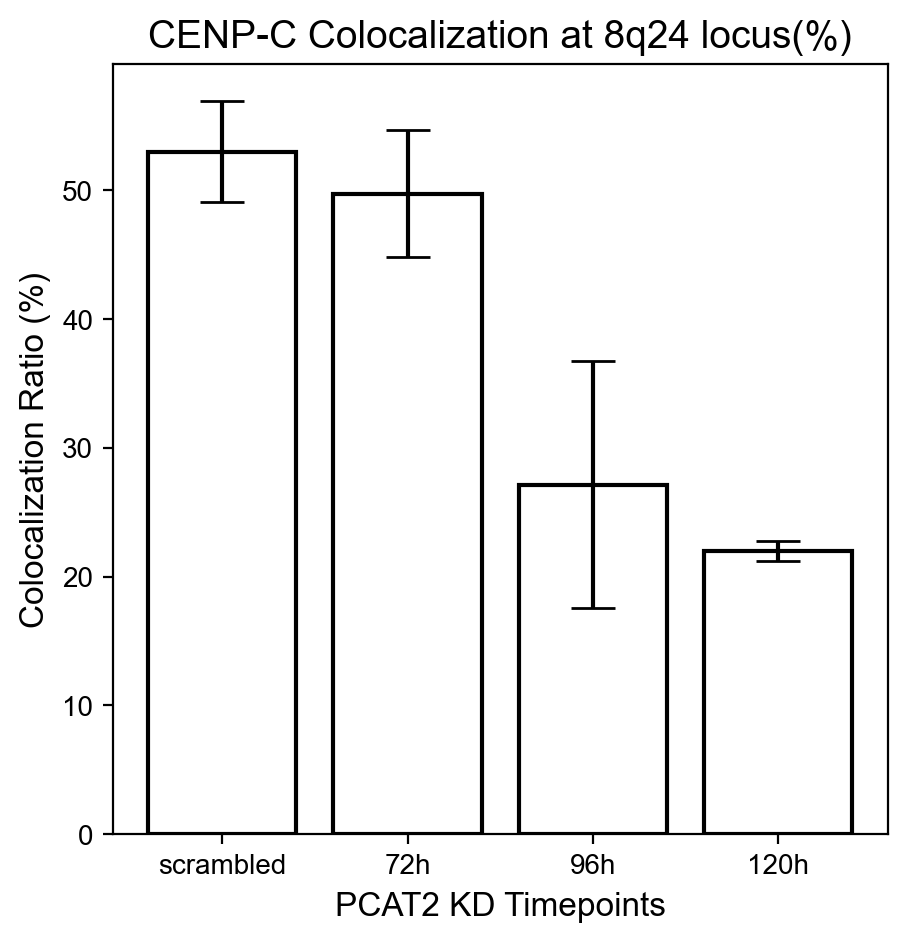

In [31]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.sans-serif'] = ['Arial']

# Prepare data for plotting
timepoints = list(ratios_grouped.keys())
means = [ratios_grouped[tp]['mean']*100 for tp in timepoints]
stds = [ratios_grouped[tp]['std']*100 for tp in timepoints]

plt.figure(figsize=(5, 5), dpi=200)
plt.bar(timepoints, means, yerr=stds, capsize=8, color='white', edgecolor='black', linewidth=1.5)
plt.xlabel('PCAT2 KD Timepoints', fontsize=12)
plt.ylabel('Colocalization Ratio (%)', fontsize=12)
plt.title('CENP-C Colocalization at 8q24 locus(%)', fontsize=14)
plt.show()

Creating comprehensive codeflow diagram for Figure 2 colocalization analysis...


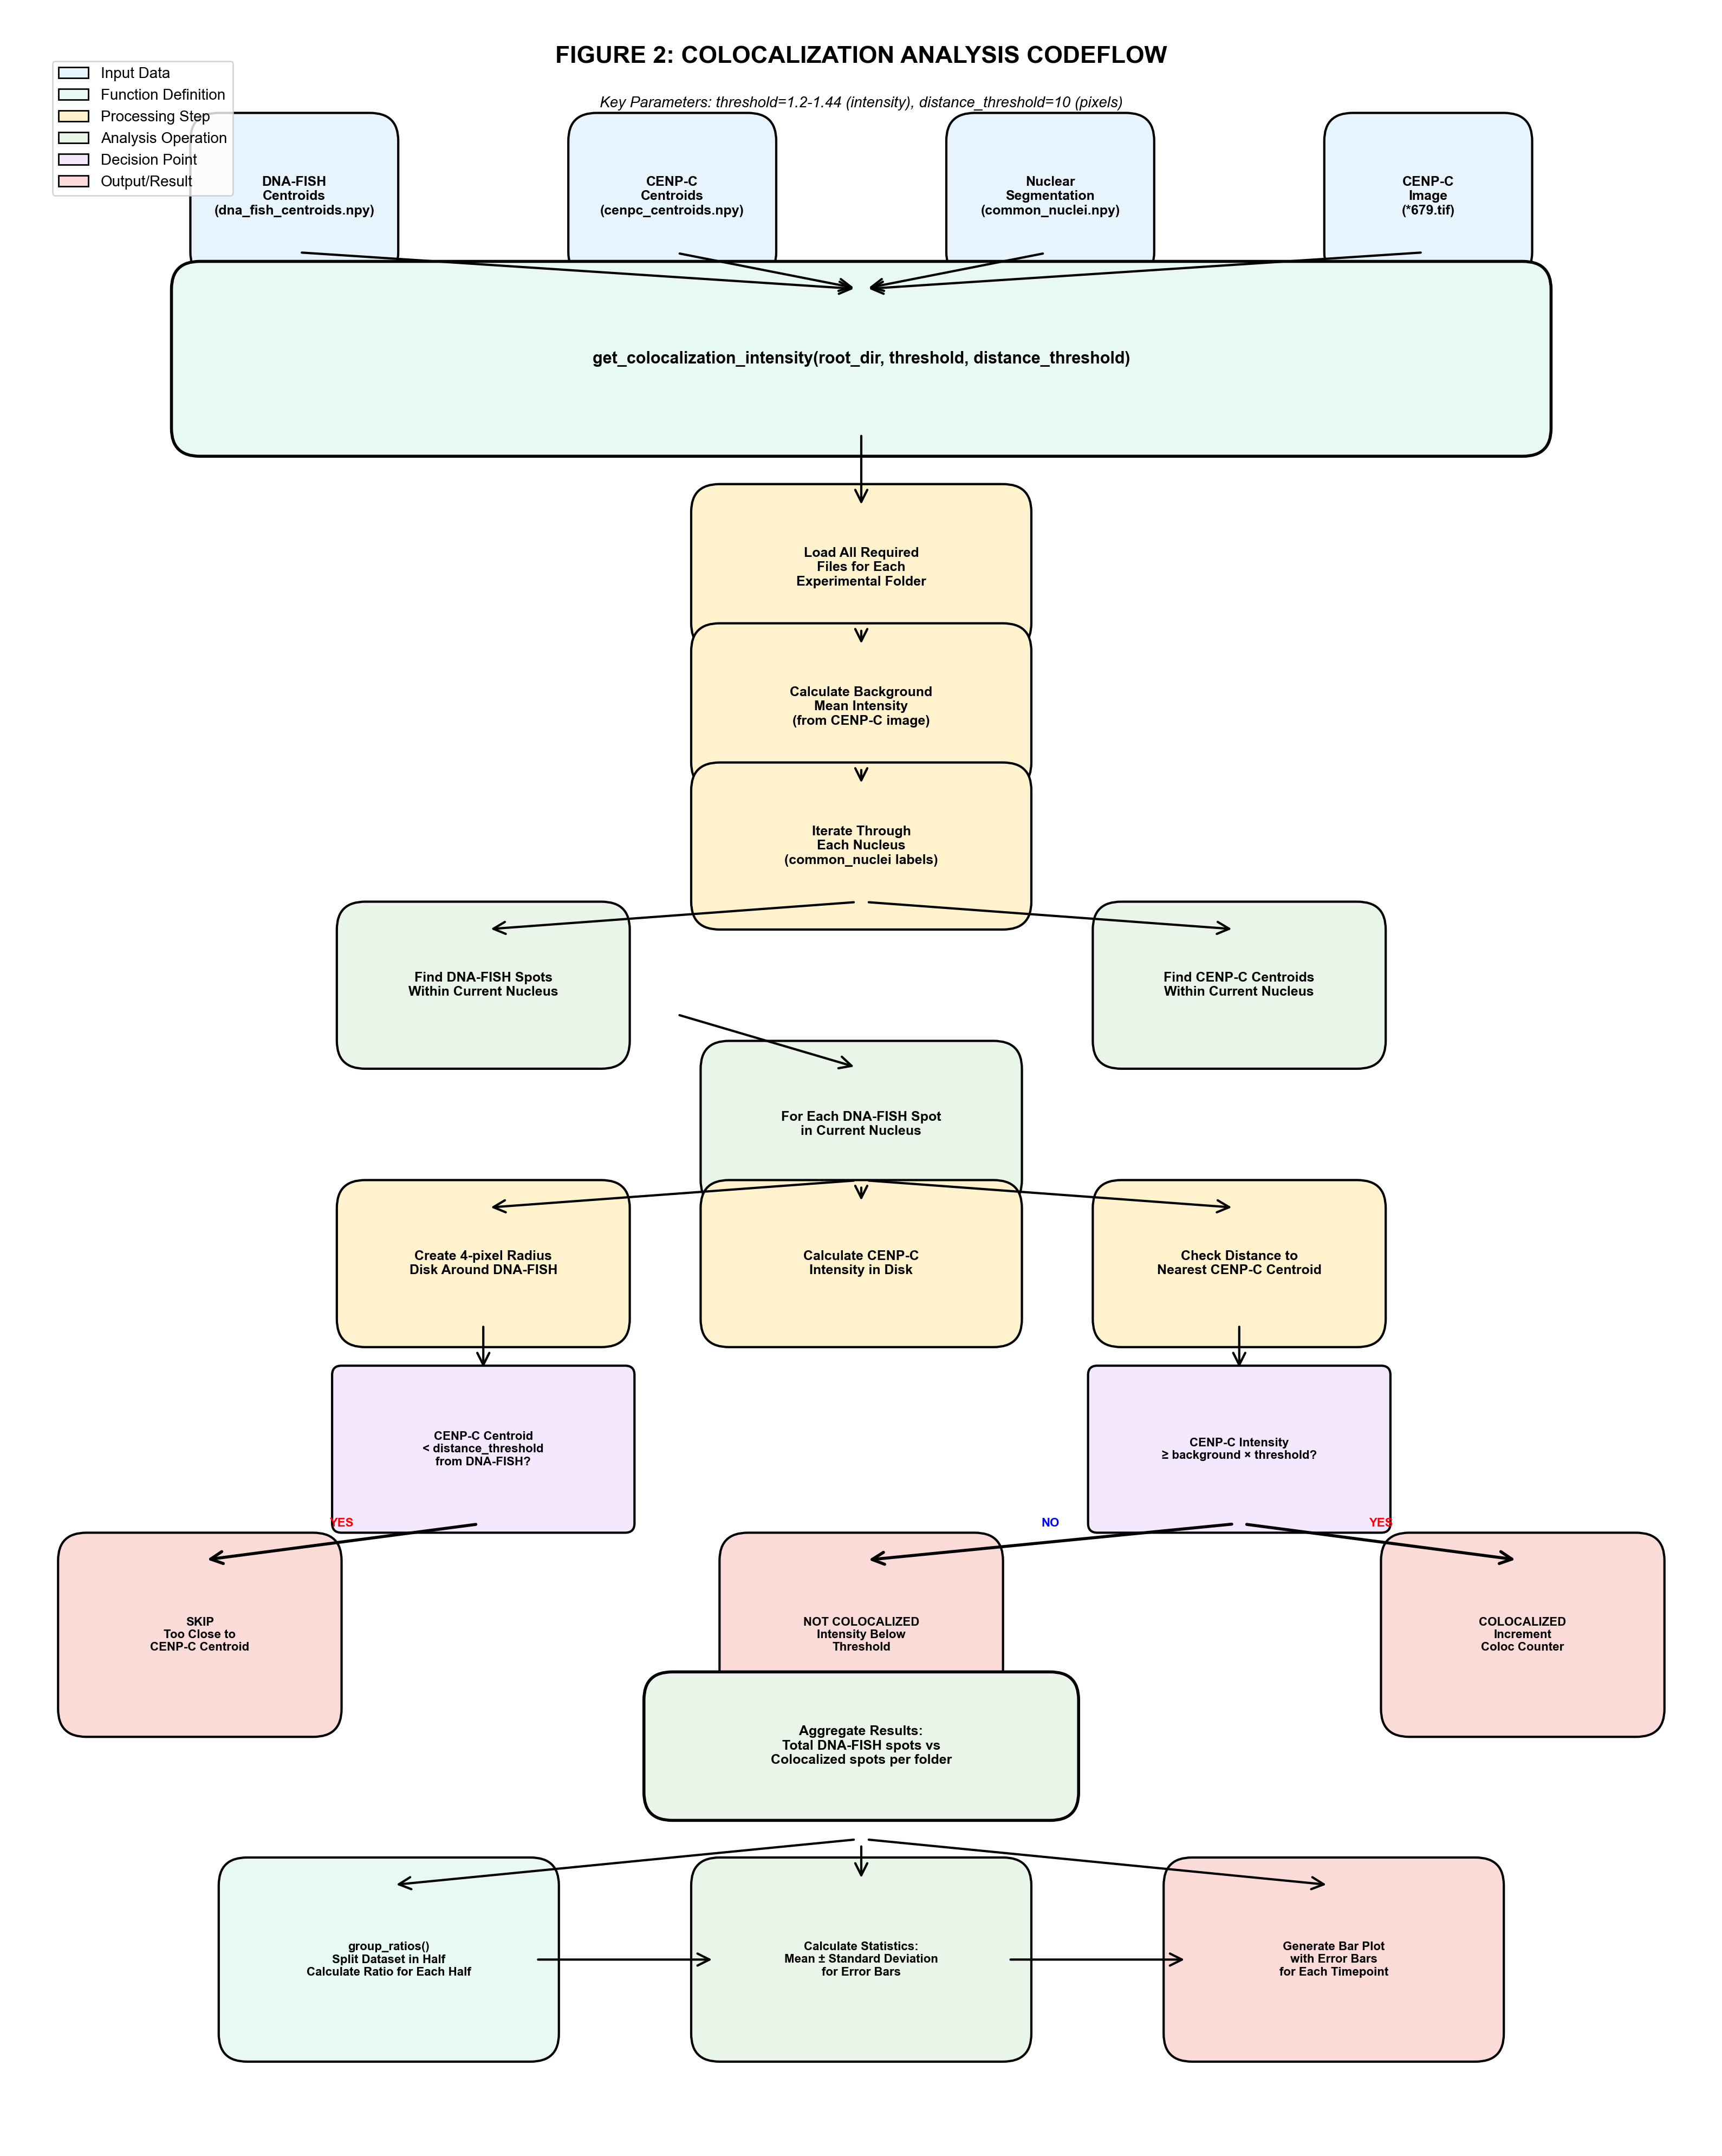


CODEFLOW DIAGRAM EXPLANATION

🔍 ANALYSIS PIPELINE OVERVIEW:
1. Load input data: DNA-FISH centroids, CENP-C centroids, nuclear segmentation, CENP-C image
2. For each nucleus, identify DNA-FISH spots and CENP-C centroids within it
3. For each DNA-FISH spot, check colocalization with CENP-C signal
4. Apply distance filter to avoid counting nearby CENP-C centroids
5. Apply intensity threshold to determine true colocalization
6. Aggregate results and perform statistical analysis
7. Generate publication-quality bar plot with error bars

⚙️ KEY DECISION POINTS:
• Distance Check: Skip DNA-FISH spots too close to CENP-C centroids (<10 pixels)
• Intensity Threshold: Count as colocalized if CENP-C intensity ≥ background × threshold
• Statistical Splitting: Divide datasets in half for error estimation

📊 OUTPUT:
• Colocalization ratios for each timepoint (scrambled, 72h, 96h, 120h)
• Error bars based on dataset splitting
• Publication-ready bar chart showing CENP-C colocalization at 8q24 locus

C

In [34]:
# =============================================================================
# CODEFLOW VISUALIZATION FOR FIGURE 2 COLOCALIZATION ANALYSIS
# =============================================================================

def create_codeflow_diagram():
    """
    Create a comprehensive flowchart showing the colocalization analysis pipeline.
    This diagram illustrates the step-by-step process from data loading to final plotting.
    """
    
    # Create figure with appropriate size for detailed flowchart
    fig, ax = plt.subplots(figsize=(16, 20), dpi=200)
    
    # Define color scheme for different types of operations
    colors = {
        'input': '#E8F4FD',       # Light blue for input data
        'process': '#FFF2CC',     # Light yellow for processing steps
        'analysis': '#E8F5E8',    # Light green for analysis operations
        'output': '#FADBD8',      # Light red for outputs/results
        'decision': '#F4E8FF',    # Light purple for decision points
        'function': '#E8F8F5'     # Light mint for function definitions
    }
    
    # Define box styling
    box_style = "round,pad=0.3"
    
    # =============================================================================
    # STEP 1: INPUT DATA SECTION
    # =============================================================================
    
    # Main input data sources
    inputs = [
        {'text': 'DNA-FISH\nCentroids\n(dna_fish_centroids.npy)', 'pos': (2, 18), 'color': colors['input']},
        {'text': 'CENP-C\nCentroids\n(cenpc_centroids.npy)', 'pos': (6, 18), 'color': colors['input']},
        {'text': 'Nuclear\nSegmentation\n(common_nuclei.npy)', 'pos': (10, 18), 'color': colors['input']},
        {'text': 'CENP-C\nImage\n(*679.tif)', 'pos': (14, 18), 'color': colors['input']}
    ]
    
    for inp in inputs:
        bbox = FancyBboxPatch((inp['pos'][0]-0.8, inp['pos'][1]-0.6), 1.6, 1.2,
                             boxstyle=box_style, facecolor=inp['color'], 
                             edgecolor='black', linewidth=1.5)
        ax.add_patch(bbox)
        ax.text(inp['pos'][0], inp['pos'][1], inp['text'], 
                ha='center', va='center', fontsize=9, fontweight='bold')
    
    # =============================================================================
    # STEP 2: MAIN FUNCTION DEFINITION
    # =============================================================================
    
    func_box = FancyBboxPatch((1, 15.5), 14, 1.5,
                             boxstyle=box_style, facecolor=colors['function'], 
                             edgecolor='black', linewidth=2)
    ax.add_patch(func_box)
    ax.text(8, 16.25, 'get_colocalization_intensity(root_dir, threshold, distance_threshold)', 
            ha='center', va='center', fontsize=11, fontweight='bold')
    
    # Draw arrows from inputs to function
    for inp in inputs:
        arrow = ConnectionPatch((inp['pos'][0], inp['pos'][1]-0.6), (8, 17),
                               "data", "data", arrowstyle="->", 
                               shrinkA=5, shrinkB=5, mutation_scale=20, 
                               fc="black", lw=1.5)
        ax.add_patch(arrow)
    
    # =============================================================================
    # STEP 3: PROCESSING PIPELINE
    # =============================================================================
    
    # Processing steps with detailed explanations
    processes = [
        {'text': 'Load All Required\nFiles for Each\nExperimental Folder', 'pos': (8, 14), 'color': colors['process']},
        {'text': 'Calculate Background\nMean Intensity\n(from CENP-C image)', 'pos': (8, 12.5), 'color': colors['process']},
        {'text': 'Iterate Through\nEach Nucleus\n(common_nuclei labels)', 'pos': (8, 11), 'color': colors['process']},
        {'text': 'Find DNA-FISH Spots\nWithin Current Nucleus', 'pos': (4, 9.5), 'color': colors['analysis']},
        {'text': 'Find CENP-C Centroids\nWithin Current Nucleus', 'pos': (12, 9.5), 'color': colors['analysis']},
    ]
    
    # Draw processing boxes
    for i, proc in enumerate(processes):
        if i < 3:  # Main pipeline boxes
            width, height = 3, 1.2
        else:  # Side analysis boxes
            width, height = 2.5, 1.2
            
        bbox = FancyBboxPatch((proc['pos'][0]-width/2, proc['pos'][1]-height/2), 
                             width, height, boxstyle=box_style, 
                             facecolor=proc['color'], edgecolor='black', linewidth=1.5)
        ax.add_patch(bbox)
        ax.text(proc['pos'][0], proc['pos'][1], proc['text'], 
                ha='center', va='center', fontsize=9, fontweight='bold')
    
    # Draw arrows between processing steps
    process_arrows = [
        ((8, 15.5), (8, 14.6)),  # Function to first process
        ((8, 13.4), (8, 13.1)),  # Between processes
        ((8, 11.9), (8, 11.6)),  # Between processes
        ((8, 10.4), (4, 10.1)),  # Split to DNA-FISH
        ((8, 10.4), (12, 10.1)), # Split to CENP-C
    ]
    
    for start, end in process_arrows:
        arrow = ConnectionPatch(start, end, "data", "data", arrowstyle="->", 
                               shrinkA=5, shrinkB=5, mutation_scale=20, 
                               fc="black", lw=1.5)
        ax.add_patch(arrow)
    
    # =============================================================================
    # STEP 4: COLOCALIZATION ANALYSIS CORE
    # =============================================================================
    
    # Core analysis loop
    core_analysis = [
        {'text': 'For Each DNA-FISH Spot\nin Current Nucleus', 'pos': (8, 8), 'color': colors['analysis']},
        {'text': 'Create 4-pixel Radius\nDisk Around DNA-FISH', 'pos': (4, 6.5), 'color': colors['process']},
        {'text': 'Calculate CENP-C\nIntensity in Disk', 'pos': (8, 6.5), 'color': colors['process']},
        {'text': 'Check Distance to\nNearest CENP-C Centroid', 'pos': (12, 6.5), 'color': colors['process']},
    ]
    
    for proc in core_analysis:
        width = 2.8 if proc['pos'][0] == 8 else 2.5
        height = 1.2
        bbox = FancyBboxPatch((proc['pos'][0]-width/2, proc['pos'][1]-height/2), 
                             width, height, boxstyle=box_style, 
                             facecolor=proc['color'], edgecolor='black', linewidth=1.5)
        ax.add_patch(bbox)
        ax.text(proc['pos'][0], proc['pos'][1], proc['text'], 
                ha='center', va='center', fontsize=9, fontweight='bold')
    
    # Draw arrows for core analysis
    core_arrows = [
        ((6, 9.2), (8, 8.6)),    # From DNA-FISH to core loop
        ((8, 7.4), (4, 7.1)),    # To disk creation
        ((8, 7.4), (8, 7.1)),    # To intensity calculation
        ((8, 7.4), (12, 7.1)),   # To distance check
    ]
    
    for start, end in core_arrows:
        arrow = ConnectionPatch(start, end, "data", "data", arrowstyle="->", 
                               shrinkA=5, shrinkB=5, mutation_scale=20, 
                               fc="black", lw=1.5)
        ax.add_patch(arrow)
    
    # =============================================================================
    # STEP 5: DECISION LOGIC
    # =============================================================================
    
    # Decision diamonds
    decisions = [
        {'text': 'CENP-C Centroid\n< distance_threshold\nfrom DNA-FISH?', 'pos': (4, 4.5), 'color': colors['decision']},
        {'text': 'CENP-C Intensity\n≥ background × threshold?', 'pos': (12, 4.5), 'color': colors['decision']},
    ]
    
    for dec in decisions:
        # Create diamond shape for decision
        bbox = FancyBboxPatch((dec['pos'][0]-1.5, dec['pos'][1]-0.8), 3, 1.6,
                             boxstyle="round,pad=0.1", facecolor=dec['color'], 
                             edgecolor='black', linewidth=1.5)
        ax.add_patch(bbox)
        ax.text(dec['pos'][0], dec['pos'][1], dec['text'], 
                ha='center', va='center', fontsize=8, fontweight='bold')
    
    # Decision arrows
    decision_arrows = [
        ((4, 5.9), (4, 5.3)),    # To first decision
        ((12, 5.9), (12, 5.3)),  # To second decision
    ]
    
    for start, end in decision_arrows:
        arrow = ConnectionPatch(start, end, "data", "data", arrowstyle="->", 
                               shrinkA=5, shrinkB=5, mutation_scale=20, 
                               fc="black", lw=1.5)
        ax.add_patch(arrow)
    
    # =============================================================================
    # STEP 6: OUTCOMES
    # =============================================================================
    
    # Outcome boxes
    outcomes = [
        {'text': 'SKIP\nToo Close to\nCENP-C Centroid', 'pos': (1, 2.5), 'color': colors['output']},
        {'text': 'NOT COLOCALIZED\nIntensity Below\nThreshold', 'pos': (8, 2.5), 'color': colors['output']},
        {'text': 'COLOCALIZED\nIncrement\nColoc Counter', 'pos': (15, 2.5), 'color': colors['output']},
    ]
    
    for out in outcomes:
        bbox = FancyBboxPatch((out['pos'][0]-1.2, out['pos'][1]-0.8), 2.4, 1.6,
                             boxstyle=box_style, facecolor=out['color'], 
                             edgecolor='black', linewidth=1.5)
        ax.add_patch(bbox)
        ax.text(out['pos'][0], out['pos'][1], out['text'], 
                ha='center', va='center', fontsize=8, fontweight='bold')
    
    # Outcome arrows with labels
    outcome_arrows = [
        ((4, 3.7), (1, 3.3), 'YES'),    # Skip path
        ((12, 3.7), (8, 3.3), 'NO'),    # Not colocalized
        ((12, 3.7), (15, 3.3), 'YES'),  # Colocalized
    ]
    
    for start, end, label in outcome_arrows:
        arrow = ConnectionPatch(start, end, "data", "data", arrowstyle="->", 
                               shrinkA=5, shrinkB=5, mutation_scale=20, 
                               fc="red" if label == "YES" else "blue", lw=2)
        ax.add_patch(arrow)
        
        # Add label to arrow
        mid_x, mid_y = (start[0] + end[0])/2, (start[1] + end[1])/2
        ax.text(mid_x, mid_y + 0.2, label, ha='center', va='center', 
                fontsize=8, fontweight='bold', 
                color="red" if label == "YES" else "blue")
    
    # =============================================================================
    # STEP 7: STATISTICAL ANALYSIS SECTION
    # =============================================================================
    
    # Results aggregation
    results_box = FancyBboxPatch((6, 0.8), 4, 1,
                                boxstyle=box_style, facecolor=colors['analysis'], 
                                edgecolor='black', linewidth=2)
    ax.add_patch(results_box)
    ax.text(8, 1.3, 'Aggregate Results:\nTotal DNA-FISH spots vs\nColocalized spots per folder', 
            ha='center', va='center', fontsize=9, fontweight='bold')
    
    # Statistical processing
    stats_processes = [
        {'text': 'group_ratios()\nSplit Dataset in Half\nCalculate Ratio for Each Half', 'pos': (3, -1), 'color': colors['function']},
        {'text': 'Calculate Statistics:\nMean ± Standard Deviation\nfor Error Bars', 'pos': (8, -1), 'color': colors['analysis']},
        {'text': 'Generate Bar Plot\nwith Error Bars\nfor Each Timepoint', 'pos': (13, -1), 'color': colors['output']},
    ]
    
    for stat in stats_processes:
        bbox = FancyBboxPatch((stat['pos'][0]-1.5, stat['pos'][1]-0.8), 3, 1.6,
                             boxstyle=box_style, facecolor=stat['color'], 
                             edgecolor='black', linewidth=1.5)
        ax.add_patch(bbox)
        ax.text(stat['pos'][0], stat['pos'][1], stat['text'], 
                ha='center', va='center', fontsize=8, fontweight='bold')
    
    # Final arrows
    final_arrows = [
        ((8, 0.3), (3, -0.2)),   # To group ratios
        ((8, 0.3), (8, -0.2)),   # To statistics
        ((8, 0.3), (13, -0.2)),  # To plotting
        ((4.5, -1), (6.5, -1)),  # Between stats processes
        ((9.5, -1), (11.5, -1)), # Between stats processes
    ]
    
    for start, end in final_arrows:
        arrow = ConnectionPatch(start, end, "data", "data", arrowstyle="->", 
                               shrinkA=5, shrinkB=5, mutation_scale=20, 
                               fc="black", lw=1.5)
        ax.add_patch(arrow)
    
    # =============================================================================
    # ANNOTATIONS AND LEGEND
    # =============================================================================
    
    # Add title
    ax.text(8, 19.5, 'FIGURE 2: COLOCALIZATION ANALYSIS CODEFLOW', 
            ha='center', va='center', fontsize=16, fontweight='bold')
    
    # Add subtitle with key parameters
    ax.text(8, 19, 'Key Parameters: threshold=1.2-1.44 (intensity), distance_threshold=10 (pixels)', 
            ha='center', va='center', fontsize=10, style='italic')
    
    # Create legend
    legend_elements = [
        mpatches.Rectangle((0, 0), 1, 1, facecolor=colors['input'], edgecolor='black', label='Input Data'),
        mpatches.Rectangle((0, 0), 1, 1, facecolor=colors['function'], edgecolor='black', label='Function Definition'),
        mpatches.Rectangle((0, 0), 1, 1, facecolor=colors['process'], edgecolor='black', label='Processing Step'),
        mpatches.Rectangle((0, 0), 1, 1, facecolor=colors['analysis'], edgecolor='black', label='Analysis Operation'),
        mpatches.Rectangle((0, 0), 1, 1, facecolor=colors['decision'], edgecolor='black', label='Decision Point'),
        mpatches.Rectangle((0, 0), 1, 1, facecolor=colors['output'], edgecolor='black', label='Output/Result'),
    ]
    
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.02, 0.98))
    
    # Set axis limits and remove axes
    ax.set_xlim(-1, 17)
    ax.set_ylim(-3, 20)
    ax.axis('off')
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# =============================================================================
# CREATE AND DISPLAY THE CODEFLOW DIAGRAM
# =============================================================================

print("Creating comprehensive codeflow diagram for Figure 2 colocalization analysis...")
create_codeflow_diagram()

print("\n" + "="*60)
print("CODEFLOW DIAGRAM EXPLANATION")
print("="*60)

print("\n🔍 ANALYSIS PIPELINE OVERVIEW:")
print("1. Load input data: DNA-FISH centroids, CENP-C centroids, nuclear segmentation, CENP-C image")
print("2. For each nucleus, identify DNA-FISH spots and CENP-C centroids within it")
print("3. For each DNA-FISH spot, check colocalization with CENP-C signal")
print("4. Apply distance filter to avoid counting nearby CENP-C centroids")
print("5. Apply intensity threshold to determine true colocalization")
print("6. Aggregate results and perform statistical analysis")
print("7. Generate publication-quality bar plot with error bars")

print("\n⚙️ KEY DECISION POINTS:")
print("• Distance Check: Skip DNA-FISH spots too close to CENP-C centroids (<10 pixels)")
print("• Intensity Threshold: Count as colocalized if CENP-C intensity ≥ background × threshold")
print("• Statistical Splitting: Divide datasets in half for error estimation")

print("\n📊 OUTPUT:")
print("• Colocalization ratios for each timepoint (scrambled, 72h, 96h, 120h)")
print("• Error bars based on dataset splitting")
print("• Publication-ready bar chart showing CENP-C colocalization at 8q24 locus")

print("\nCodeflow diagram complete! 🎉")